In [1]:
import numpy as np
import pandas as pd

from scipy.sparse import csc_matrix
from scipy.sparse.linalg import inv
from scipy.special import gamma as g_func
from scipy.optimize import fsolve,root,least_squares

import matplotlib.pyplot as plt

from tqdm import tqdm

import openpyxl
import warnings

ImportError: DLL load failed while importing _multiarray_umath: 找不到指定的模块。

### Estimation Part
This part I'll replicate the estimation part of Eaton and Kortum (2002), which estimate the trade barrier measure ($\kappa$) and technology ($T$). The model implmented here is as follows, 
$$
\frac{X_{ni}}{X_{nn}} = \frac{\pi_{ni}}{\pi_{nn}}=\frac{T_i}{T_n}(\frac{\omega_i}{\omega_n})^{-\theta\beta}(\frac{p_i}{p_n})^{-\theta(1-\beta)}d_{ni}^{-θ} \\
\ln{\frac{X'_{ni}}{X'_{nn}}}=-\theta\ln{d_{ni}}+S_i-S_n
$$

In [2]:
# Analyse N countries
N = 20

# including Countries, education year, pop density, human capital
# r&d, total labor, GDP, CPI, 3 secotrs prop, annual income
uni_data = pd.read_csv('.\\clean data\\unilateral_trade.csv')
# including Countries, Xni/Xnn, trade prime, 6 discrete distance,
# common language, both EU, both EFTA, capital distance
bi_data = pd.read_csv('.\\clean data\\bilateral_trade.csv')
# country code
country_code = pd.read_csv(".\\clean data\\country_code.csv")

Here is the data for this equation,
$$
\ln{\frac{X'_{ni}}{X'_{nn}}}=-\theta\ln{d_{ni}}+S_i-S_n
$$
I'll use FGLS to estimate this equation.

In [3]:
# Data processing
# fixed parameters
beta = 0.3 
theta = 4

# trade prime
log_trade = np.array(bi_data['trade'])
log_trade_prime = np.array(bi_data['trade_prime'])

# Kappa_ni
geo_data = bi_data[['dist1','dist2','dist3','dist4','dist5','dist6',
                    'border','common_language','both_in_EU','both_in_EFTA']]
# M_i (import fixed effect)
import_n_dummy = np.kron(np.eye(N),np.ones(N).reshape(-1,1))
import_n_dummy_relative = import_n_dummy[:,1:] - import_n_dummy[:,0].reshape(-1,1)
dni_data = np.concatenate((np.array(geo_data),import_n_dummy_relative),axis=1)

# S_i (export fixed effect)
export_i_dummy = np.kron(np.ones(N).reshape(-1,1),np.eye(N)) 
Si_data = export_i_dummy - import_n_dummy
Si_data_relative = Si_data[:,1:] - Si_data[:,0].reshape(-1,1) # relative to USA

#### FGLS

In [4]:
# FGLS
# OLS
Y = log_trade_prime
X = np.concatenate((dni_data,Si_data_relative),axis=1)
valid_index = np.where(~(bi_data.import_country == bi_data.export_country))[0]
bi_data_valid = bi_data.reset_index(drop=True)

beta_ols = np.linalg.solve(X.T@X,X.T@Y)
res_ols = (Y - X@beta_ols).reshape(-1,1)

# iterate for gls
res = res_ols.reshape(-1,1) # residual
count = 20

# iterate until residual mean is small enough or count reaches zero
while (res.mean() > 1e5) | (count > 0):
    # residual matrix
    res_matrix = res @ res.T
    sigma12 = np.diag(res_matrix).mean()

    # calculate sigma 2
    pair_code1 = bi_data_valid[['import_country','export_country']].reset_index(drop=False).rename(columns={'index':'id1'})
    pair_code2 = bi_data_valid[['import_country','export_country']].reset_index(drop=False).rename(columns={'index':'id2',
                                                                                                  'import_country':'export_country',
                                                                                                  'export_country':'import_country'})
    pair_code = pd.merge(pair_code1,pair_code2,
                         on=['import_country','export_country'])
    pair_code = np.array(pair_code[pair_code.id1!=pair_code.id2][['id1','id2']])
    sigma2 = res_matrix[pair_code[:,0],pair_code[:,1]].mean()
    sigma1 = sigma12 - sigma2


    res_matrix = np.zeros((N**2,N**2))
    res_matrix[pair_code[:,0],pair_code[:,1]] = sigma2
    res_matrix[np.arange(N**2-N),np.arange(N**2-N)] = sigma12 # not include n=i
    res_matrix[np.arange(N**2),np.arange(N**2)] = sigma12 # include n=i

    # inverse
    res_matrix_inv = inv(csc_matrix(res_matrix))

    # GLS
    beta_gls = np.linalg.solve(X.T@res_matrix_inv@X,X.T@res_matrix_inv@Y)
    S1 = -beta_gls[-(N-1):].sum()
    S_estimate = np.concatenate((np.array([S1]),beta_gls[-(N-1):]))
    M1 = -beta_gls[10:-(N-1)].sum()
    M_estimate = np.concatenate((np.array([M1]),beta_gls[10:-(N-1)]))
    res_gls = Y - X@beta_gls


    res = res_gls.reshape(-1,1) # upload residual
    count -= 1

print("Mean residual:",res.mean())

# beta variance
res_sigma = np.mean(np.diag((res_gls.reshape(-1,1)@res_gls.reshape(1,-1))@res_matrix_inv))
beta_var = res_sigma * inv(csc_matrix(X.T@res_matrix_inv@X))

S1_variance = np.sqrt(np.sum(beta_var[-(N-1):,-(N-1):]))
S_variance = np.concatenate((np.array([S1_variance]),np.sqrt(np.diag(beta_var.toarray()))[-(N-1):]))
M1_variance = np.sqrt(np.sum(beta_var[10:-(N-1),10:-(N-1)]))
M_variance = np.concatenate((np.array([M1_variance]),np.sqrt(np.diag(beta_var.toarray()))[10:-(N-1)]))

beta_var = np.sqrt(np.diag(beta_var.toarray()))


dni_valid = np.concatenate((np.array(geo_data),import_n_dummy),axis=1)
dni_beta = np.concatenate((beta_gls[:10],M_estimate)).reshape(-1,1)
dni_estimate =  np.exp(-(dni_valid@dni_beta + res)/theta)

# check the result of calculation
print('The number of false error:',np.sum(np.abs((dni_valid@dni_beta) + (Si_data@S_estimate).reshape(-1,1) + res - Y.reshape(-1,1))>1e-8))

# replace n==i with 1
same_pair_code = bi_data[bi_data.import_country==bi_data.export_country].index
# transform into matrix
dni_country = bi_data[['import_country','export_country']]
dni_country['dni'] = dni_estimate
dni_country = dni_country.pivot_table(values='dni',
                                      index='import_country',
                                      columns='export_country')
dni_estimate = np.array(dni_country)


# Technology
wage = uni_data['Annual income']
tech = np.exp((S_estimate + theta*np.log(wage))*beta)

Mean residual: -0.010928875938731016
The number of false error: 0


C:\Users\Zhu Dai\AppData\Local\Temp\ipykernel_21224\594203481.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dni_country['dni'] = dni_estimate


In [5]:
# save the results
code_list = uni_data['code'].tolist()
S_M_columns = [f"Source country: {code}" for code in code_list] + [f"Destination country: {code}" for code in code_list]
estimation_columns = np.array(geo_data.columns.to_list() + S_M_columns).reshape(-1,1)

beta_columns = np.concatenate((np.concatenate((beta_gls[:10],S_estimate)),M_estimate)).reshape(-1,1)

variance_columns = np.concatenate((np.concatenate((beta_var[:10],S_variance)),M_variance)).reshape(-1,1)

estimation_table = pd.DataFrame(np.concatenate((np.concatenate((estimation_columns,np.round(beta_columns,2)),axis=1),
                                               np.round(variance_columns,2)),axis=1),
                                columns=['Variables','est.','std.'])
estimation_table.to_csv('.\\results\\estimation_results.csv')

### Counterfactual Part
parameters：beta, theta, sigma(calibrate)

data：wage, dni, tech，X, deficit, tariff, labor

endogenous variable：price index, pi, wage

**Here my counterfactual change the tariff while fix other variables.**

In [22]:
# parameters
N = N
beta = beta
theta = theta
sigma = 10
gamma = g_func((theta+1-sigma)/theta) ** (1/(1-sigma))
epsilon = (beta ** -beta) * ((1-beta) ** (beta-1))


# data
# already has dni, tech, wage
# Xni
nominal = pd.read_csv('.\\clean data\\nominal_variables.csv')
Xni = np.array(nominal.loc[list(range(N)),[str (i+1) for i in range(N)]]) * 1000 # 转换为美元为单位
expenditure = Xni.sum(axis=1)


# deficit
import_i_data = expenditure - np.diag(Xni)
export_n_dummy = Xni.sum(axis=0) - np.diag(Xni)
deficit = import_i_data - export_n_dummy

# labor
labor = uni_data['labor']

In [ ]:
# set the condition for counterfactual
# load the tariff data
tariff_data = np.load('.\\clean data\\tariff_data.npy')

# Kappa equals to dni_estimate here
Kappa = dni_estimate # * (1+tariff_data) # use it to calculate trade cost

# deficit (consider tariff)
reality_Pni = Xni/expenditure.reshape(-1,1)

# tariffs as Kappa_hat
Kappa_hat = np.array(nominal['Original Reciprocal Tariffs'].iloc[:N]).reshape(1,-1)+1
#Kappa_hat = np.ones(N).reshape(1,-1) # to check the model
Kappa_hat = np.concatenate((Kappa_hat,np.ones((N-1,N))),axis=0)

tariff_data_new = tariff_data.copy() + Kappa_hat - 1

I take an exhat algebra to set up the model for counterfactual:
$$
\hat{c}_i = \hat{w}_i^\beta \hat{P}_i^{1 - \beta} \\
\hat{P}_n = \left[ \sum_{i=1}^N \pi_{ni} \left( \hat{c}_i \hat{\kappa}_{ni} \right)^{-\theta} \right]^{-1/\theta} \\
\pi_{ni}' = \frac{\pi_{ni} \left( \hat{c}_i \hat{\kappa}_{ni} \right)^{-\theta}}{\sum_{h=1}^N \pi_{nh} \left( \hat{c}_h \hat{\kappa}_{nh} \right)^{-\theta}} \\
\sum_{i=1}^N \frac{\pi_{ni}'}{1 + \tau_{ni}'} X_n' - D_n = \sum_{i=1}^N \frac{\pi_{in}'}{1 + \tau_{in}'} X_i' \\
X_n' = \frac{\hat{w}_n w_n L_n}{\beta} + \sum_{i=1}^N \frac{\tau_{ni}' \pi_{ni}'}{1 + \tau_{ni}'} X_n' + D_n
$$

In [26]:
# function for counterfactual and test
def price_hat_func(P_hat,wage_hat,Pi,Kappa_hat,beta,theta,count=0):
    # check whether the input is valid
    if np.any(P_hat <= 0) or np.any(wage_hat <= 0) or np.any(Kappa_hat <= 0):
        print(f"❌ Invalid input detected at call #{count}")
        if np.any(P_hat <= 0):
            print("P_hat min:", np.min(P_hat))
        if np.any(wage_hat <= 0):
            print("wage_hat min:", np.min(wage_hat))
        if np.any(Kappa_hat <= 0):
            print("Kappa_hat min:", np.min(Kappa_hat))


    left = P_hat
    right = (Pi * np.power(Kappa_hat,-theta)) @ (np.power(wage_hat,-theta*beta) * np.power(P_hat,1-beta))
    return left - right


def Pni_hat_func(Pi,wage_hat,Kappa_hat,P_hat,beta,theta):
    denominator = (Pi * np.power(Kappa_hat,-theta)) @ (np.power(wage_hat,-theta*beta) * np.power(P_hat,1-beta))
    denominator = denominator[:,np.newaxis]  # ensure the shape for matrix multiplication
    
    numrator = Pi * np.power(Kappa_hat,-theta) * (np.power(wage_hat,-theta*beta) * np.power(P_hat,1-beta))
    return numrator / denominator


def trade_inv_hat_func(wage,wage_hat,labor,tau,Pni,Defi,beta):
    N = wage.shape[0]
    param = np.ones(N) - ((tau*Pni/(1+tau))@np.ones(N))
    return (wage_hat*wage*labor/beta + Defi)/param


def trade_func(X,Pni,tau,Defi):
    # Pni: exporter i's goods proportion in importer n
    X = np.array(X).reshape(-1,1) # ensure the shape
    Defi = np.array(Defi).reshape(-1,1)

    right = Defi + (X.T@(Pni/(1+tau))).T
    left = (Pni/(1+tau))@np.ones(N)
    left = np.array(left)[:,np.newaxis]
    return right/left


def labor_excess_func(X,wage,labor,tau,Pni,Defi,wage_hat):
    X = np.array(X).reshape(-1,1) # ensure the shape
    Defi = np.array(Defi).reshape(-1,1)
    labor = np.array(labor).reshape(-1,1)
    wage = np.array(wage).reshape(-1,1)
    wage_hat = np.array(wage_hat).reshape(-1,1)

    tariff_pt = ((tau*Pni/(1+tau))@np.ones(X.shape[0])).reshape(-1,1) * X
    return (beta*(X - tariff_pt - Defi)/(wage*wage_hat) - labor)/labor

In [27]:
def EK_counterfactual(data,parameter,count):
    # data
    wage = data[0]
    tariff_data = data[1]
    deficit = data[2]
    labor = data[3]
    Pni = data[4]
    Kappa_hat = data[5]
    #GE_price = data[6]
    
    # parameters
    theta = parameter[0]
    beta = parameter[1]

    N = wage.shape[0]

    # initial value
    P_hat = np.random.uniform(0.8, 1.2, N)
    wage_hat = np.random.uniform(0.8, 1.2, N)
    wage_hat_ini = wage_hat.copy()

    ### maximum and minimum price
    price_min = ((gamma**(-theta)) * (epsilon ** -theta) * tech * np.power(wage,-theta*beta))**(1/beta)
    price_max = (np.ones((N,N))@((gamma**(-theta)) * (epsilon ** -theta) * tech * np.power(wage,-theta*beta)))**(1/beta)
    #P_hat_min = price_min/GE_price
    #P_hat_max = price_max/GE_price

    # restore the epsilon
    wage_history = []
    price_history = []


    for i in tqdm(range(count)):
        P_hat_new = least_squares(price_hat_func,P_hat,
                                  args=(wage_hat_ini, Pni, Kappa_hat, beta, theta, count),
                                  #bounds=(P_hat_min, P_hat_max),
                                  ).x

        Pni_new = Pni_hat_func(Pni,wage_hat,Kappa_hat,P_hat_new,beta,theta)
        expenditure_new = trade_inv_hat_func(wage,wage_hat,labor,tariff_data,Pni_new,deficit,beta)
        expenditure_for_wage = trade_func(expenditure_new,Pni_new,tariff_data,deficit)
        labor_excess_ratio = labor_excess_func(expenditure_for_wage,wage,labor,tariff_data,Pni_new,deficit,wage_hat)

        
        tolerance = np.sqrt(np.sum(np.power(labor_excess_ratio,2)))

        

        count -= 1

        # convergence check
        if tolerance<1e-8:
            print("Tolerance is",tolerance)
            break

        else:
            # validation
            P_hat = P_hat * 0.5 + P_hat_new * 0.5
            wage_hat = np.array(wage_hat).reshape(-1,1)
            wage_hat = wage_hat * (1+np.minimum(labor_excess_ratio,1)*0.5)
            wage_hat = wage_hat.reshape(-1)

            wage_hat_ini = wage_hat.copy()
            wage_history.append(np.mean(wage_hat))
            price_history.append(np.mean(P_hat_new))


        
    welfare_hat = wage_hat/np.power(P_hat_new,-1/theta)
    
    if count == 0:
        print("Not converge! Epsilon is:",tolerance)

    

    return np.power(P_hat_new,-1/theta),wage_hat,welfare_hat,expenditure_new,Pni_new,wage_history,price_history

In [28]:
# Tariff counterfactual, keep deficit fixed (real data)
data = [wage,tariff_data_new,deficit,labor,reality_Pni,Kappa_hat]
param = [theta,beta]
P_hat_tariff42,wage_hat_tariff42,welfare_hat_tariff42,expenditure_tariff42,Pni_tariff42,wage_history_tariff42,price_history_tariff42 = EK_counterfactual(data,param,500)

  0%|          | 0/500 [00:00<?, ?it/s]

 14%|█▍        | 71/500 [00:00<00:01, 328.19it/s]

Tolerance is 4.2479661545179656e-09


Here I visualize the results. The first figure show the process of convergence of price and wage, while the second figure compare the difference between price change, wage change and welfare change.

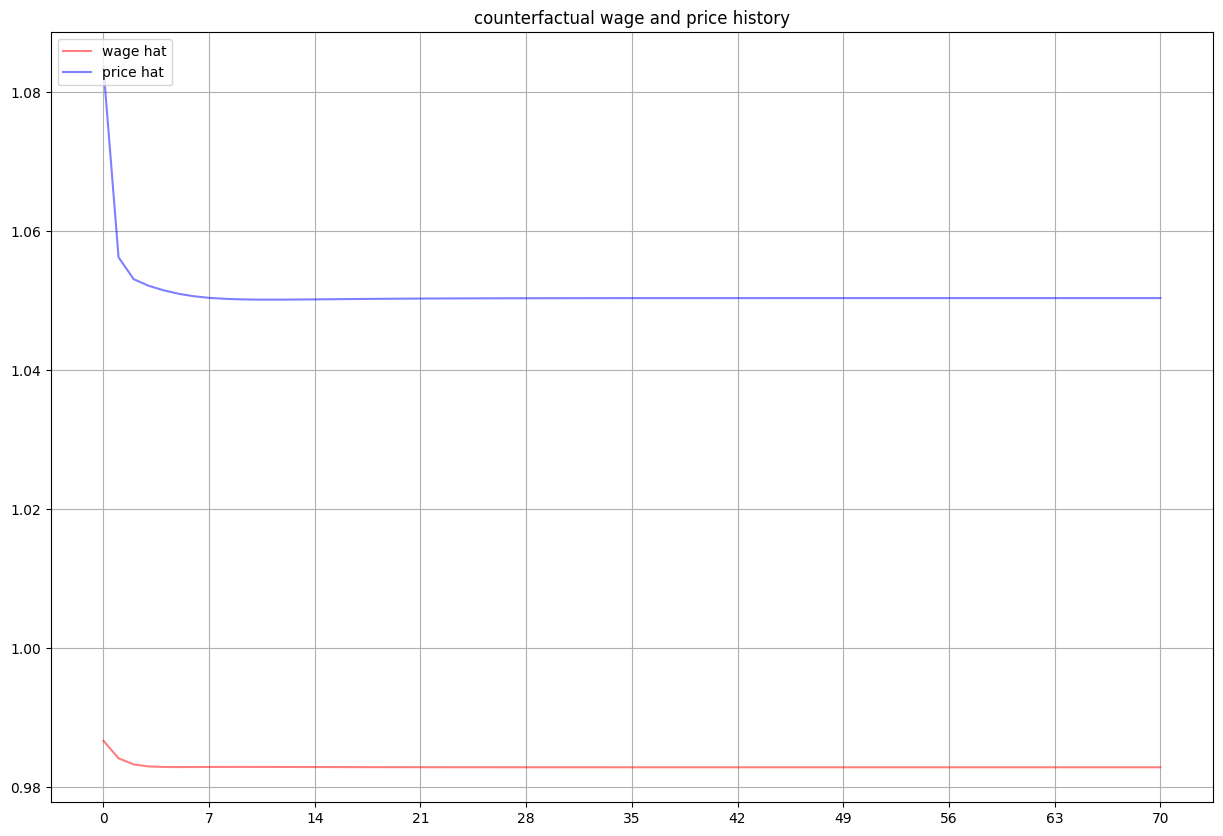

<Figure size 640x480 with 0 Axes>

In [31]:
fig,ax = plt.subplots(figsize=(15,10))

# for x
x = np.arange(0,len(wage_history_tariff42)+1,round(len(wage_history_tariff42)/10))

ax.plot(wage_history_tariff42,color='red',label='wage hat',alpha=0.5)
ax.plot(price_history_tariff42,color='blue',label='price hat',alpha=0.5)

ax.set_xticks(x)

ax.legend(loc='upper left')
ax.grid()
ax.set_title('counterfactual wage and price history')
plt.show()
plt.savefig('.\\fig\\tariff_counterfactual_history.png',dpi=300)

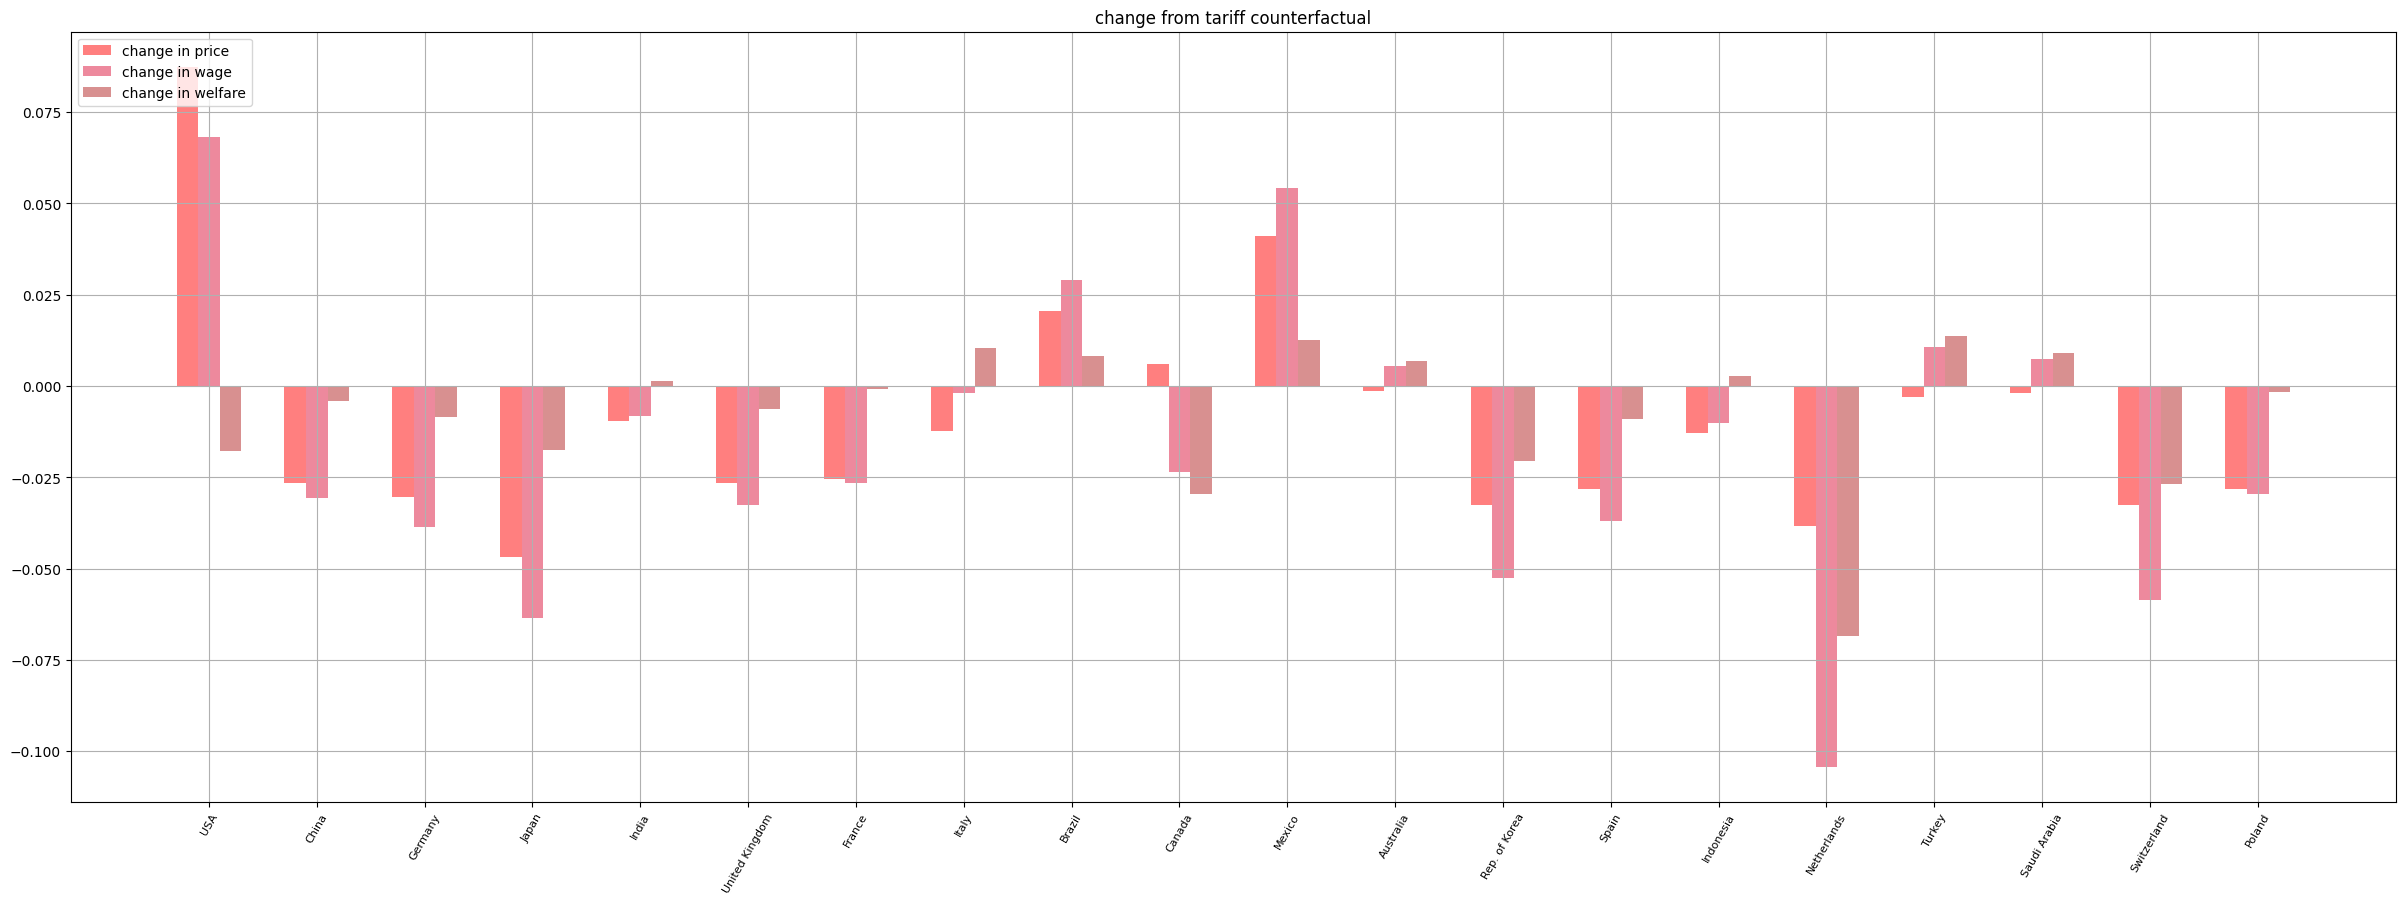

<Figure size 640x480 with 0 Axes>

In [32]:
fig,ax = plt.subplots(figsize=(30,10))
width = 0.2

# for x
categories = country_code['Country']
x = np.arange(len(categories))

ax.bar(x-width,P_hat_tariff42-1,width=width,color='red',label='change in price',alpha=0.5)
ax.bar(x,wage_hat_tariff42-1,width=width,color='crimson',label='change in wage',alpha=0.5)
ax.bar(x+width,welfare_hat_tariff42-1,width=width,color='firebrick',label='change in welfare',alpha=0.5)

ax.set_xticks(x)
ax.set_xticklabels(categories, rotation=60, fontsize=8)

ax.legend(loc='upper left')
ax.grid()
ax.set_title('change from tariff counterfactual')
plt.show()
plt.savefig('.\\fig\\tariff_counterfactual_change.png',dpi=300)